In [12]:
# Core libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)


### Load and Label all files

In [13]:
import os, re, pandas as pd, numpy as np

def load_sisfall_dataset(root="SisFall_dataset"):
    all_signals, all_labels, meta = [], [], []

    # Constants for bit-to-physical conversion
    g_factor_ADXL345 = (2*16)/(2**13)
    g_factor_MMA8451Q = (2*8)/(2**14)
    deg_factor_ITG3200 = (2*2000)/(2**16)

    for subj_folder in sorted(os.listdir(root)):
        subj_path = os.path.join(root, subj_folder)
        if not os.path.isdir(subj_path):
            continue

        for file in sorted(os.listdir(subj_path)):
            if not file.endswith(".txt"):
                continue

            # Label from filename prefix (Fxx → fall=1, Dxx → ADL=0)
            label = 1 if file.startswith("F") else 0

            df = pd.read_csv(os.path.join(subj_path, file),
                             sep='[;,\\s]+', engine='python', header=None)
            df = df.dropna(axis=1, how='all')
            if df.shape[1] < 9:    # skip corrupted
                continue
            df = df.iloc[:, :9].astype(np.float32)

            # Convert to physical units
            df.iloc[:, 0:3] *= g_factor_ADXL345
            df.iloc[:, 3:6] *= deg_factor_ITG3200
            df.iloc[:, 6:9] *= g_factor_MMA8451Q

            all_signals.append(df.values)
            all_labels.append(label)
            meta.append({
                "file": file,
                "subject": subj_folder,
                "samples": len(df),
                "label": label
            })

    print(f"Loaded {len(all_signals)} recordings "
          f"({sum(all_labels)} falls, {len(all_labels)-sum(all_labels)} ADL)")
    return all_signals, np.array(all_labels), pd.DataFrame(meta)


In [14]:
signals, labels, meta = load_sisfall_dataset("SisFall_dataset")
meta.head()


Loaded 4505 recordings (1798 falls, 2707 ADL)


,file,subject,samples,label
0,D01_SA01_R01.txt,SA01,19999,0
1,D02_SA01_R01.txt,SA01,20000,0
2,D03_SA01_R01.txt,SA01,20000,0
3,D04_SA01_R01.txt,SA01,20000,0
4,D05_SA01_R01.txt,SA01,5000,0


### Windowing the sequences
Why? Important so that models can consume equal sized inputs. We will proceed by creating fixed-length windows i.e 1s = 200 samples

In [15]:
def create_windows(signals, labels, window_size=200, overlap=0.5):
    X, y = [], []
    step = int(window_size * (1 - overlap))
    for sig, lab in zip(signals, labels):
        for i in range(0, len(sig) - window_size, step):
            window = sig[i:i+window_size]
            X.append(window)
            y.append(lab)
    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.int64)
    print(f"Created {len(X)} windows of shape {X.shape[1:]}")
    return X, y

X, y = create_windows(signals, labels, window_size=200, overlap=0.5)


Created 149632 windows of shape (200, 9)


#### Check: How many 1-second windows are created for ADLs vs Falls

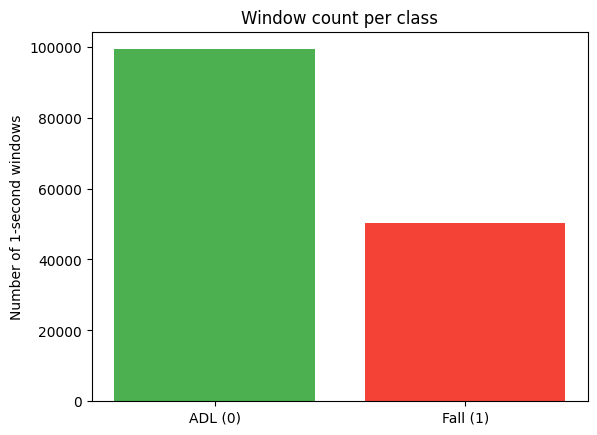

In [16]:
import matplotlib.pyplot as plt

unique, counts = np.unique(y, return_counts=True)
plt.bar(["ADL (0)", "Fall (1)"], counts, color=["#4caf50", "#f44336"])
plt.title("Window count per class")
plt.ylabel("Number of 1-second windows")
plt.show()


This helps confirm that the dataset is imbalanced i.e falls are much rarer. 

In [19]:
import random
idx = random.choice(np.where(y == 1)[0])  # pick a fall window
window = X[idx]

fig, axes = plt.subplots(3, 1, figsize=(12,6), sharex=True)
axes[0].plot(window[:,0], label="Acc1-X")
axes[0].plot(window[:,1], label="Acc1-Y")
axes[0].plot(window[:,2], label="Acc1-Z")
axes[0].legend(); axes[0].set_ylabel("g")

axes[1].plot(window[:,3], label="Gyro-X")
axes[1].plot(window[:,4], label="Gyro-Y")
axes[1].plot(window[:,5], label="Gyro-Z")
axes[1].legend(); axes[1].set_ylabel("°/s")

axes[2].plot(window[:,6], label="Acc2-X")
axes[2].plot(window[:,7], label="Acc2-Y")
axes[2].plot(window[:,8], label="Acc2-Z")
axes[2].legend(); axes[2].set_ylabel("g")
axes[2].set_xlabel("Sample (200 Hz ≈ 1 s)")
plt.suptitle("Example fall window")
plt.show()


IndexError: tuple index out of range

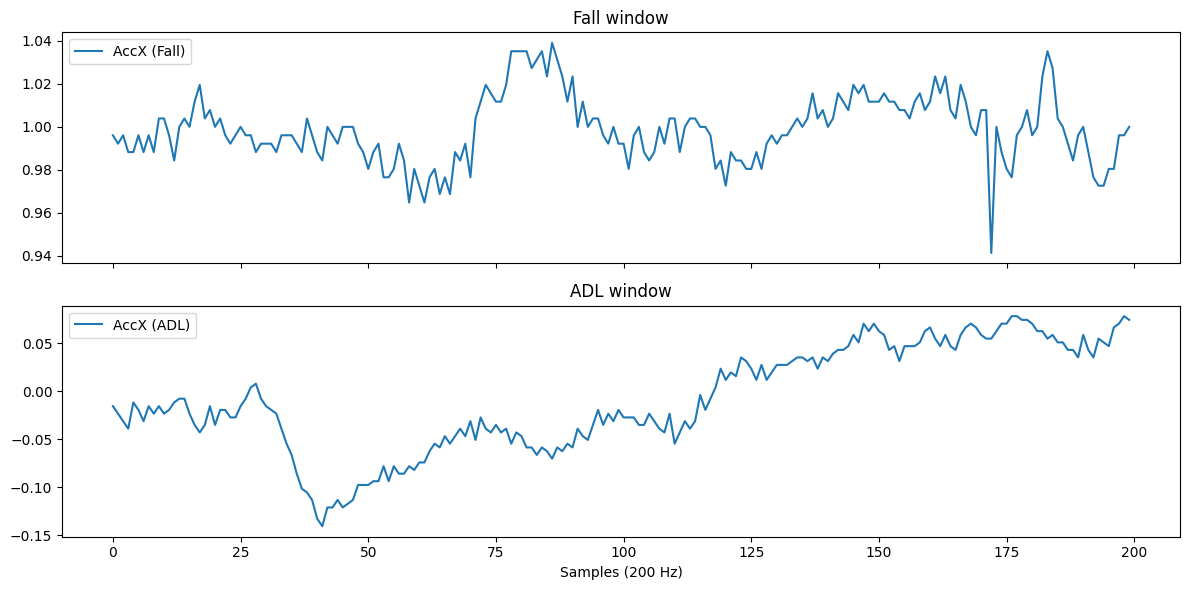

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(12,6), sharex=True)

fall_idx = random.choice(np.where(y == 1)[0])
adl_idx  = random.choice(np.where(y == 0)[0])

axes[0].plot(X[fall_idx][:,0], label="AccX (Fall)")
axes[0].set_title("Fall window")
axes[0].legend()

axes[1].plot(X[adl_idx][:,0], label="AccX (ADL)")
axes[1].set_title("ADL window")
axes[1].legend()

plt.xlabel("Samples (200 Hz)")
plt.tight_layout()
plt.show()
